In [1]:
import gym
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import json
import random
import numpy as np
import time
import networkx as nx
import keyboard

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
from IPython import display

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\weiss\anaconda3\envs\niproject\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device('cpu')

SAVE_MODELS = False  # Save models to file so you can test later
MODEL_PATH = "./pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = False  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = True  # Load model from file
LOAD_FILE_EPISODE = 900  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 100000  # Max episode
MAX_STEP = 100000 # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.97  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.99  # Epsilon decay rate by step

RENDER_GAME_WINDOW = True  # Opens a new window to render the game (Won't work on colab default)

FPS = 3

In [3]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

In [4]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = environment.action_space.n

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def preProcess(self, image):
        """
        Process image crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [5]:
action_dict = {
    'NOOP': 'x',
    'FIRE': 'O',
    'LEFT': '<-',
    'RIGHT': '->',
    'LEFTFIRE': '<-O',
    'RIGHTFIRE': 'O->'
}

def showActionTree(env, agent, state, episode, step, number_steps_ahead):
    SCALE = 4
    Q_VALUE_SENSITIVITY = 30
    
    actions = env.unwrapped.get_action_meanings()
    snapshot = env.ale.cloneState()
    current_snapshot = None
    actionTree = nx.Graph()
    actionTree.add_node('0', pos=(0, 0))
    
    action = None
    for i in range(number_steps_ahead):
        prev_action = action
        action = agent.act(state)
        with torch.no_grad():
            _state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
            q_values = agent.online_model.forward(_state)
            q_values_softmax = torch.nn.functional.softmax(Q_VALUE_SENSITIVITY * q_values, dim=1)
            
            current_snapshot = env.ale.cloneState()
            for j in range(len(actions)):
                next_state, reward, done, info = env.step(j)
                actionTree.add_node(
                    '{}_{}'.format(str(i+1), str(j)), pos=(3 * (i+1), (len(actions) - 1) / 2 - j),
                    image=env.ale.getScreenRGB()
                )
                actionTree.add_edge(
                    '0' if i == 0 else '{}_{}'.format(str(i), str(prev_action)), 
                    '{}_{}'.format(str(i+1), str(j)), 
                    label='{}\n{}'.format(action_dict[actions[j]], round(q_values[0, j].item(), 2)),
                    width=max(SCALE * 4 * q_values_softmax[0, j].item(), 1)
                )
                env.ale.restoreState(current_snapshot)
                
            next_state, reward, done, info = env.step(action)
            next_state = agent.preProcess(next_state)  # Process image
            next_state = np.stack((next_state, state[0], state[1], state[2]))
            state = next_state
    pos = nx.get_node_attributes(actionTree, 'pos')
    fig = plt.figure(episode * MAX_STEP + step, figsize=(SCALE * 12, SCALE* 6))
    ax = fig.add_subplot(111)
    nx.draw(actionTree, pos=pos, width=list(nx.get_edge_attributes(actionTree, 'width').values()), node_size=0)
    nx.draw_networkx_edge_labels(actionTree, pos=pos, font_size=SCALE * 7, edge_labels=nx.get_edge_attributes(actionTree, 'label'))
    
    for i in range(number_steps_ahead):
        for j in range(len(actions)):
            coords = ax.transData.transform((3 * (i+1), (len(actions) - 1) / 2 - j))
            fig.figimage(actionTree.nodes['{}_{}'.format(str(i+1), str(j))]['image'], xo=coords[0] - 500, yo=coords[1] - 300, zorder=1)
    display.clear_output(wait=True)
    display.display(fig)
    env = env.ale.restoreState(snapshot)

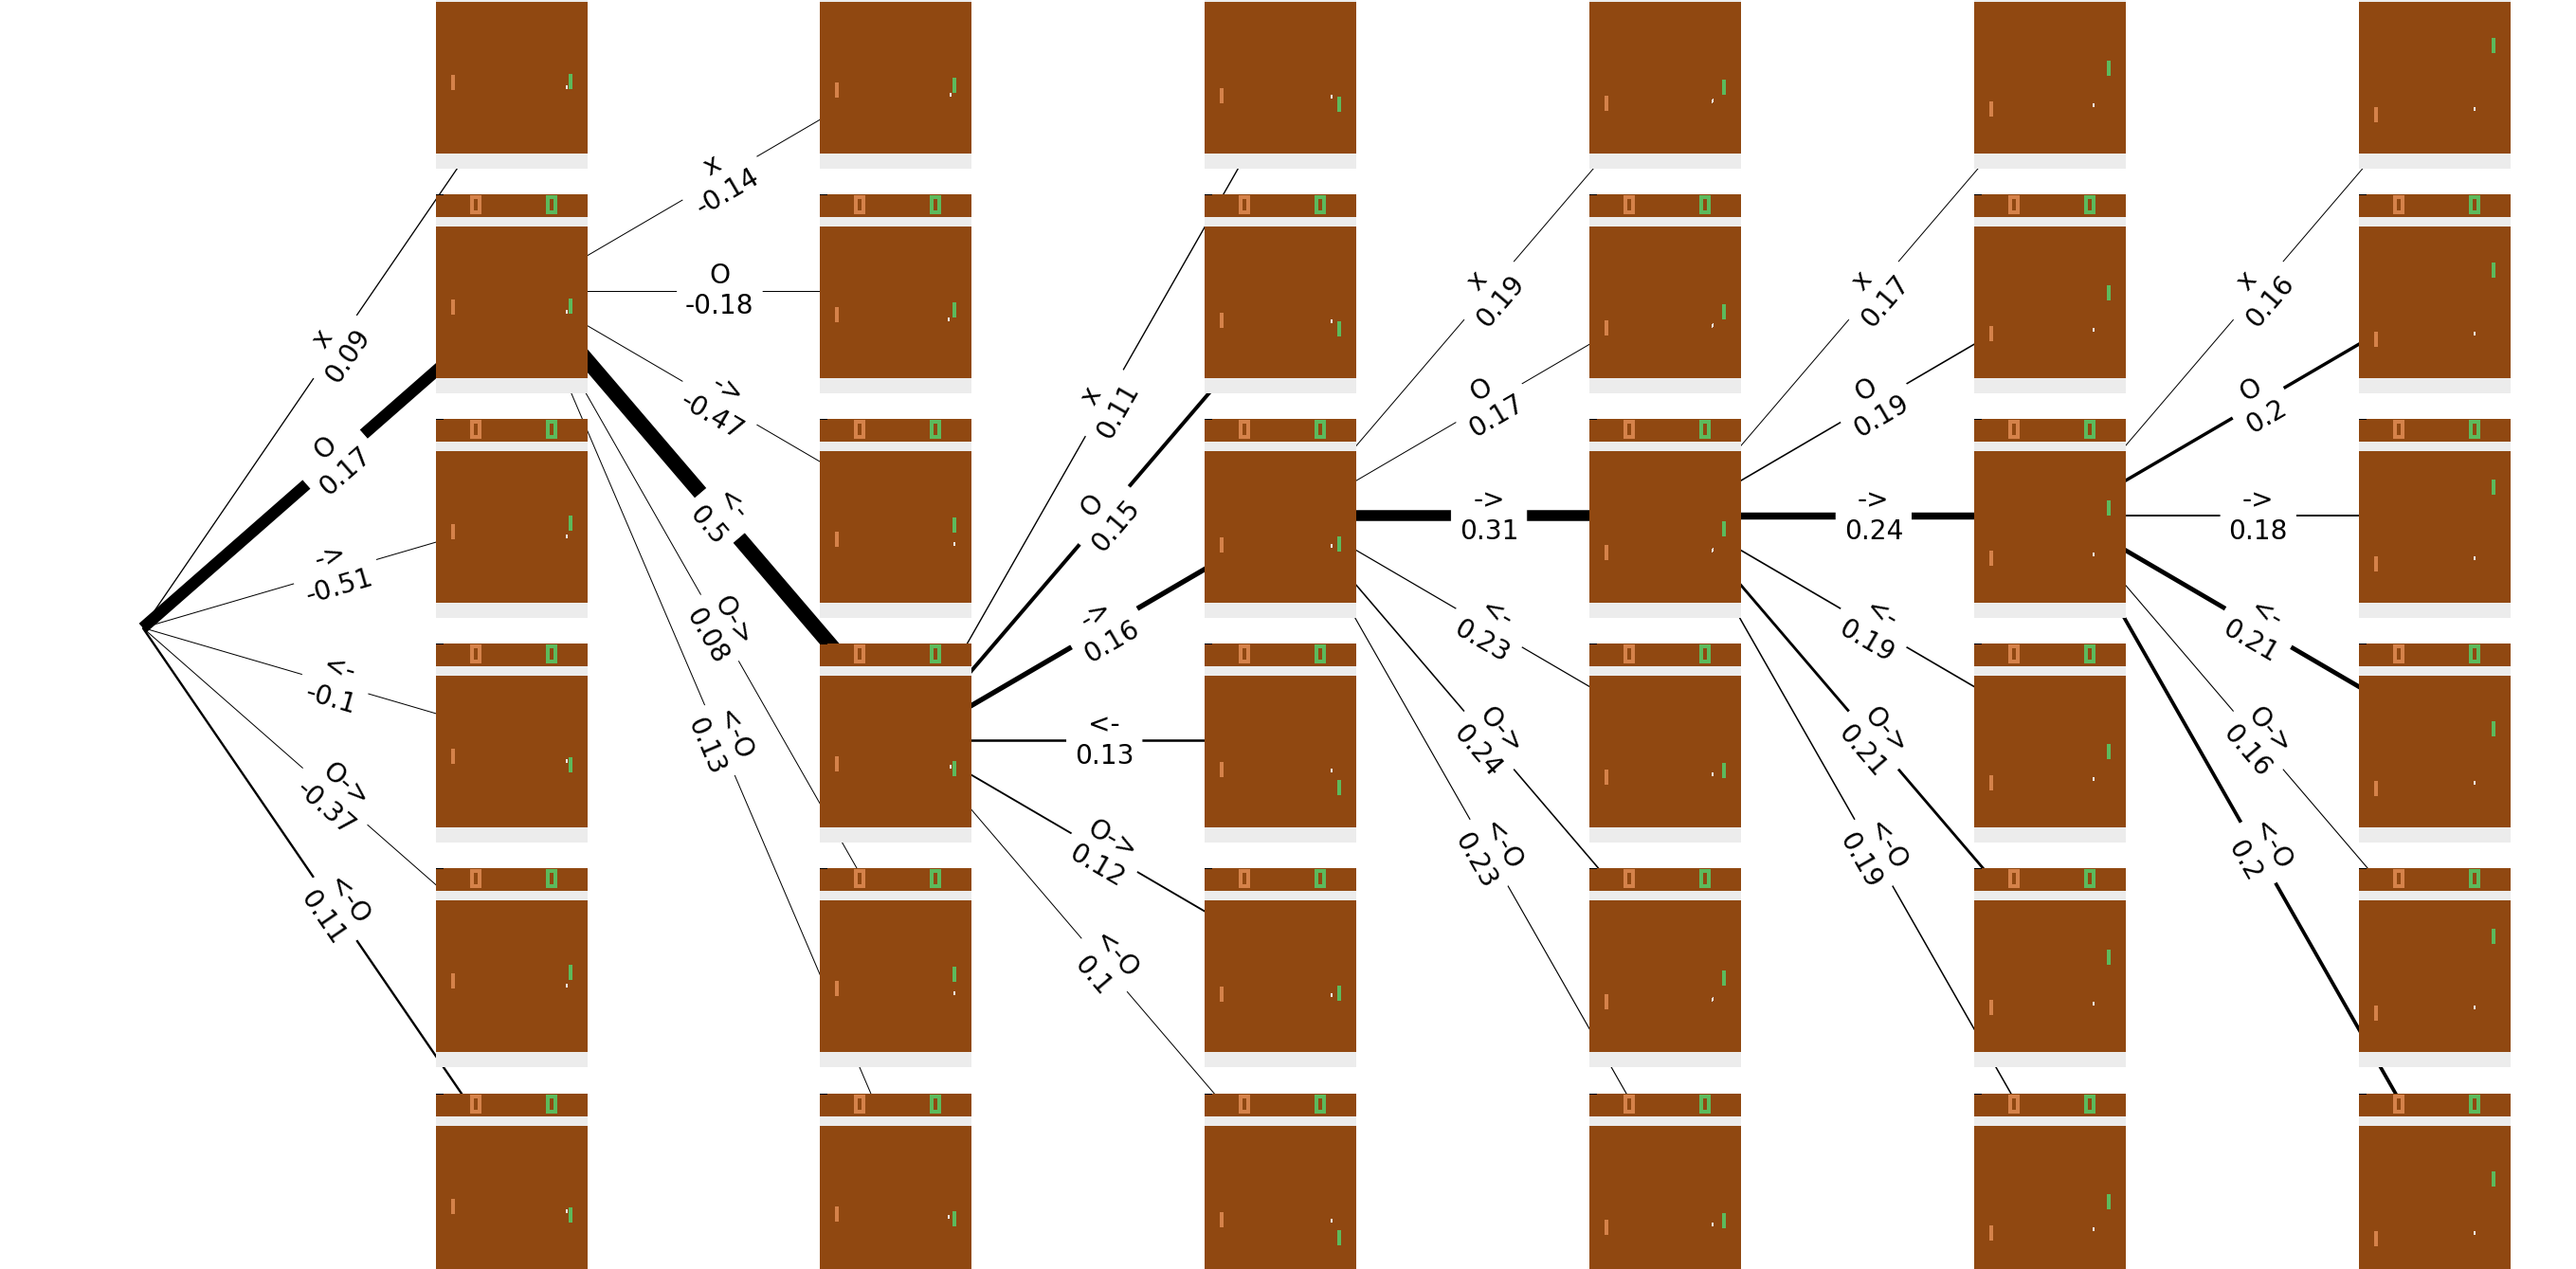

In [ ]:
environment = gym.make(ENVIRONMENT)  # Get env
agent = Agent(environment)  # Create Agent

if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl", map_location="cpu"))
    

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulkative sum of all steps in episodes
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    state = environment.reset()  # Reset env

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):
        if keyboard.is_pressed('v'):
            input("Press Enter to continue...")
        
        time.sleep(1 / FPS)

        if RENDER_GAME_WINDOW:
            environment.render()  # Show state visually
            
        showActionTree(environment, agent, state, episode, step, 6)

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done, info = environment.step(action)  # Observe

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")

            break


In [ ]:
torch.load(MODEL_PATH+"900.pkl", map_location="cpu")